# Test isntall libraries

In [15]:
import glob, os, subprocess
import datetime

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx
from pathlib import Path

import rasterio
import rasterio.plot
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio import features

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np

import rasterstats
from rasterstats import zonal_stats

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.offline

from collections import defaultdict


import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.datasets import make_classification

import otbApplication as otb



In [13]:
path = '/export/miro/ndeffense/LBRAT2104/TEST/'

output_path = f'{path}OUTPUT/'

im_input  = f'{path}T31UFS_20200719T105031_NDVI.tif'
im_output = f'{output_path}T31UFS_20200719T105031_NDVI_x10.tif'

vec_input  = f'{path}NAMUR_2020_IN_SITU_ROI_prepared.shp'

Path(output_path).mkdir(parents=True, exist_ok=True)

### Test ``geopandas`` and ``contextily``

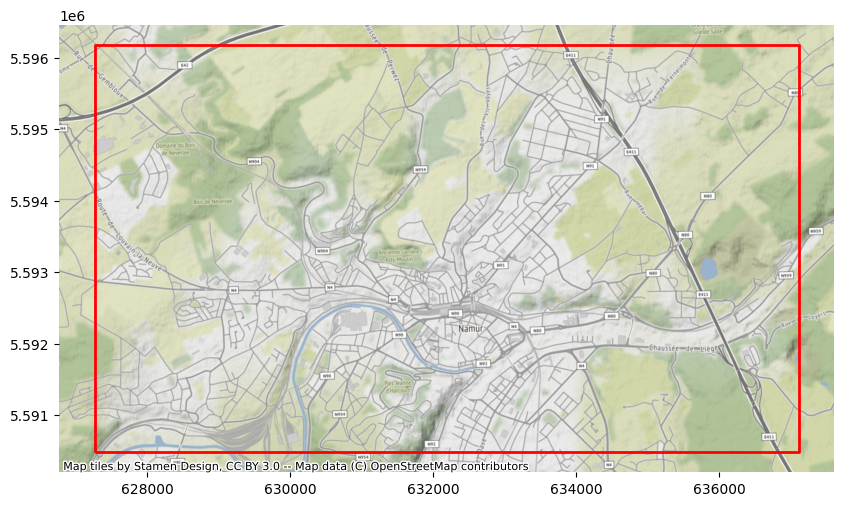

In [3]:
crs_dst = 'EPSG:32631'
roi_name = 'extent_roi_4tiles'
roi_filename = f'{roi_name}_{crs_dst[5:]}.shp'
roi_file = f'{output_path}{roi_filename}'

crs_src = 'EPSG:32631'
bbox    = [627263.7,5590485.2,637115,5596175.1]
ulx = bbox[0]
uly = bbox[1]
lrx = bbox[2]
lry = bbox[3]

# Create a list with the longitude coordinates (x)
lon_point_list = [ulx, lrx, lrx, ulx, ulx]
# Create a list with the latitude coordinates (y)
lat_point_list = [uly, uly, lry, lry, uly]
# Create a polygon object from the two list (lon and lat)
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
# Create a GeoDataFrame with the polygon object
gdf = gpd.GeoDataFrame(index=[0], crs=crs_src, geometry=[polygon_geom])       
# Reproject the GeoDataFrame to the destination CRS (needed only if you set your coordinates in WGS 84)
gdf = gdf.to_crs(crs_dst)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

gdf.boundary.plot(ax=ax,
                  color='red',
                  linewidth=2)

cx.add_basemap(ax, crs=gdf.crs.to_string())

plt.box(False)

gdf.to_file(filename=roi_file, driver='ESRI Shapefile')

### Test ``otbApplication``

In [8]:
app = otb.Registry.CreateApplication("BandMath")

app.SetParameterStringList("il", [im_input])
app.SetParameterString("out", im_output)
app.SetParameterString("exp", "im1b1 * 10")

app.ExecuteAndWriteOutput()

2023-04-25 13:39:54 (INFO): Loading metadata from official product
2023-04-25 13:39:54 (INFO) BandMath: Default RAM limit for OTB is 256 MB
2023-04-25 13:39:54 (INFO) BandMath: GDAL maximum cache size is 12880 MB
2023-04-25 13:39:54 (INFO) BandMath: OTB will use at most 64 threads
2023-04-25 13:39:54 (INFO) BandMath: Image #1 has 1 components

2023-04-25 13:39:54 (INFO): Estimated memory for full processing: 10.6815MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2023-04-25 13:39:54 (INFO): File /export/miro/ndeffense/LBRAT2104/TEST/OUTPUT/T31UFS_20200719T105031_NDVI_x10.tif will be written in 1 blocks of 986x570 pixels
Writing /export/miro/ndeffense/LBRAT2104/TEST/OUTPUT/T31UFS_20200719T105031_NDVI_x10.tif...: 100% [**************************************************] (1s)


0

### Test ``plotly``

In [9]:
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

### Test ``rasterio``

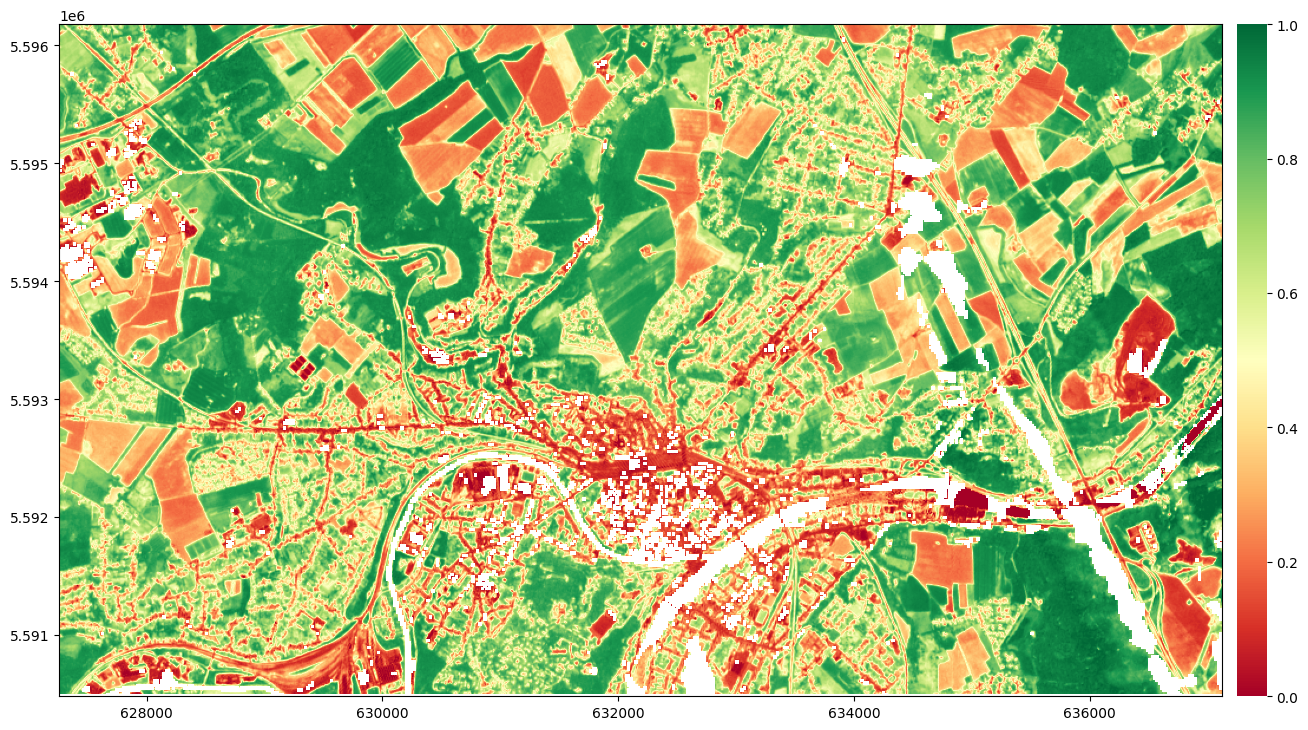

In [10]:
# Create a figure object
fig, ax = plt.subplots(1, 1, figsize=(15,15))

# Open image with rasterio
src = rasterio.open(im_input, "r")

# Get color map with matplotlib
color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

# Plot image
im_rio = rasterio.plot.show(src,
                            cmap=color_map,
                            vmin=0,
                            vmax=1,
                            ax=ax)

im_rio = im_rio.get_images()[0]

# Add color bar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)


plt.box(False)

### Test ``rasterstats``

In [14]:
src = rasterio.open(im_input, "r")
im_arr = src.read(1)
nodata_val = -10000

gdf = gpd.read_file(vec_input)


# Get transform from profile (metadata)
profile = src.profile
transform = profile['transform']

df = pd.DataFrame(zonal_stats(gdf,
                                im_arr,
                                affine=transform,
                                stats=['count','nodata','mean','std'],
                                nodata=nodata_val,
                                ))

df

/opt/modules/python_libs/lib/python3.10/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

/opt/modules/python_libs/lib/python3.10/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

/opt/modules/python_libs/lib/python3.10/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

/opt/modules/python_libs/lib/python3.10/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

/opt/modules/python_libs/lib/python3.10/site-packages/rasterstats/main.py:156: ShapelyDeprecatio

mean  count       std  nodata
0    0.493047     17  0.041720     0.0
1    0.910484    146  0.031384     0.0
2    0.895426     18  0.018982     0.0
3    0.488354     79  0.031562     0.0
4    0.828976     39  0.094717     0.0
..        ...    ...       ...     ...
532  0.937661     64  0.007761     0.0
533  0.913241     65  0.009943     0.0
534  0.950251     14  0.010176     0.0
535  0.871728     82  0.061402     0.0
536  0.924402     47  0.009952     0.0

[537 rows x 4 columns]

### Test ``sklearn``

In [16]:
X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
RandomForestClassifier(...)
print(clf.predict([[0, 0, 0, 0]]))

[1]
